In [25]:
import sys
sys.path.append("../src")
import os

import pandas as pd
import numpy as np
from etf_transformations import *
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, TimeSeriesSplit
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from scipy.stats import uniform, randint
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv("../data/preprocessed/separate_stocks_finbert_with_emb.csv")


In [27]:
df.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,0.044927,-0.013433,-0.041791,-0.007552,-0.043562,0.064962,0.024598,-0.036362,0.005609,0.006723
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,-0.005445,0.072854,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,0.022711,0.004054,-0.060530,-0.050457,0.027259,-0.058011,0.011103,-0.155406,0.021580,0.044305
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,0.024095,-0.093397,-0.001406,-0.012596,-0.084371,0.017338,0.076390,-0.135631,-0.070295,0.050183
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0.101733,0.006196,-0.056580,0.048957,-0.050295,0.028605,0.017734,-0.075114,-0.104239,0.057186


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324380 entries, 0 to 324379
Columns: 414 entries, title to emb_383
dtypes: bool(1), float64(397), int64(5), object(11)
memory usage: 1022.4+ MB


In [29]:
df.describe()

,articles_same_stock_day,articles_same_sector_day,price,price_prev_day,price_next_day,Return,Sign,Return_next_day,AbsReturn_next_day,Sign_next_day,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
count,324380.000000,324380.000000,324380.000000,324328.000000,324380.000000,324328.000000,324328.000000,324380.000000,324380.000000,324380.000000,...,324380.000000,324380.000000,324380.000000,324380.000000,324380.000000,324380.000000,324380.000000,324380.000000,324380.000000,324380.000000
mean,4.708453,22.725026,61.474066,61.432637,61.492615,0.001804,0.065246,0.000275,0.016125,0.514132,...,0.011564,0.002556,-0.040031,0.002193,-0.034535,-0.010964,0.017697,-0.101920,-0.012769,0.031535
std,8.322607,17.502838,86.649847,86.623722,86.704153,0.041623,0.995400,0.027286,0.022013,0.499801,...,0.044356,0.048861,0.043218,0.043489,0.046107,0.047714,0.049687,0.052307,0.052680,0.043921
min,1.000000,1.000000,0.268174,0.260839,0.265060,-0.529074,-1.000000,-0.753054,0.000000,0.000000,...,-0.195600,-0.207168,-0.206184,-0.214126,-0.225958,-0.208383,-0.252924,-0.282594,-0.226734,-0.185033
25%,1.000000,11.000000,23.306425,23.312603,23.311546,-0.011854,-1.000000,-0.009459,0.004397,0.000000,...,-0.018748,-0.031447,-0.069229,-0.027910,-0.065588,-0.045722,-0.014686,-0.139414,-0.049154,0.001701
50%,2.000000,18.000000,40.444548,40.429642,40.448544,0.001393,1.000000,0.000557,0.010054,1.000000,...,0.011940,0.001911,-0.041255,0.003210,-0.036245,-0.013295,0.020302,-0.104597,-0.014635,0.033393
75%,5.000000,30.000000,71.152288,71.100891,71.190870,0.015035,1.000000,0.010590,0.019831,1.000000,...,0.042195,0.037680,-0.013185,0.032917,-0.004270,0.022212,0.051504,-0.067490,0.021864,0.062747
max,169.000000,186.000000,3983.600098,4030.000000,4021.750000,0.745933,1.000000,0.557289,0.753054,1.000000,...,0.198144,0.232822,0.162369,0.205478,0.197540,0.232106,0.242711,0.157245,0.219789,0.189359


In [30]:
df.isna().sum()

title           0
date            0
stock           0
exchange        0
timestamp_et    0
               ..
emb_379         0
emb_380         0
emb_381         0
emb_382         0
emb_383         0
Length: 414, dtype: int64

In [31]:
df.nunique()

title           224675
date            216210
stock              381
exchange             2
timestamp_et    216210
                 ...  
emb_379         227592
emb_380         227532
emb_381         226385
emb_382         227603
emb_383         227347
Length: 414, dtype: int64

In [32]:
df.shape

(324380, 414)

In [33]:
df["HighVol_next_day"] = (df["HighVol_next_day"] == 1).astype(int)
df.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,0.044927,-0.013433,-0.041791,-0.007552,-0.043562,0.064962,0.024598,-0.036362,0.005609,0.006723
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,-0.005445,0.072854,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,0.022711,0.004054,-0.060530,-0.050457,0.027259,-0.058011,0.011103,-0.155406,0.021580,0.044305
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,0.024095,-0.093397,-0.001406,-0.012596,-0.084371,0.017338,0.076390,-0.135631,-0.070295,0.050183
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0.101733,0.006196,-0.056580,0.048957,-0.050295,0.028605,0.017734,-0.075114,-0.104239,0.057186


In [34]:
df["HighVol_next_day"].value_counts(normalize=True)


HighVol_next_day
0    0.80143
1    0.19857
Name: proportion, dtype: float64

In [35]:
df_catboost = df.copy()
df_catboost.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,0.044927,-0.013433,-0.041791,-0.007552,-0.043562,0.064962,0.024598,-0.036362,0.005609,0.006723
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,-0.005445,0.072854,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,0.022711,0.004054,-0.060530,-0.050457,0.027259,-0.058011,0.011103,-0.155406,0.021580,0.044305
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,0.024095,-0.093397,-0.001406,-0.012596,-0.084371,0.017338,0.076390,-0.135631,-0.070295,0.050183
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0.101733,0.006196,-0.056580,0.048957,-0.050295,0.028605,0.017734,-0.075114,-0.104239,0.057186


In [36]:
df_catboost["trading_date"] = pd.to_datetime(df_catboost["trading_date"]).dt.normalize()
df_catboost = df_catboost.sort_values("trading_date").reset_index(drop=True)

In [37]:
df_catboost["date_et"] = pd.to_datetime(df_catboost["date_et"], errors="coerce")
df_catboost["day_of_week"] = df_catboost["date_et"].dt.dayofweek
df_catboost["month"] = df_catboost["date_et"].dt.month
df_catboost.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,day_of_week,month
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,-0.041791,-0.007552,-0.043562,0.064962,0.024598,-0.036362,0.005609,0.006723,2,4
1,MRM a $15-$20+ stock - FIT new information - J...,2009-05-27 21:35:00-04:00,RF,NYSE,2009-05-27 21:35:00-04:00,21:35:00,2009-05-27,overnight,Financials,True,...,-0.018864,0.009394,0.022785,-0.050416,0.005210,-0.186018,-0.129083,0.030637,2,5
2,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481,0,6
3,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,DD,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Materials,True,...,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481,0,6
4,"Last 3 picks all took off this week 67%,62%,30...",2009-06-05 23:28:00-04:00,DD,NYSE,2009-06-05 23:28:00-04:00,23:28:00,2009-06-05,overnight,Materials,True,...,-0.048096,-0.003201,-0.076592,-0.035744,-0.010230,-0.087495,-0.078073,0.090731,4,6


In [38]:
df = df_catboost.copy()

In [39]:
target = "HighVol_next_day"
df[target] = (df[target] == 1).astype(int)

original_features = [
    "stock", "exchange", "time_et",
    "news_window", "sector", "is_trading_day",
    "articles_same_stock_day", "articles_same_sector_day",
    "price", "vol_5",
    "positive", "neutral", "negative",
    "finbert_label", "finbert_confidence",
    "day_of_week", "month"
]

embedding_features = [f"emb_{i}" for i in range(384)]


X = df[original_features + embedding_features].copy()

cat_cols = ["stock","exchange","time_et","news_window","sector","finbert_label","is_trading_day"]
X[cat_cols] = X[cat_cols].astype(str)

y = df[target].astype(int)
print("Headline-level target distribution:", y.value_counts(normalize=True).to_dict())


Headline-level target distribution: {0: 0.8014304211110426, 1: 0.1985695788889574}


In [40]:
emb_cols = [c for c in X.columns if c.startswith("emb_")]
pca = PCA(n_components=200, random_state=12)

E_pca = pca.fit_transform(X[emb_cols].values)
pca_cols = [f"pca_{i}" for i in range(E_pca.shape[1])]
X_pca = pd.DataFrame(E_pca, columns=pca_cols, index=X.index)

print(f"PCA explained variance (200 comps): {pca.explained_variance_ratio_.sum():.4f}")


PCA explained variance (200 comps): 0.9287


In [41]:
group_cols = ["stock", "trading_date"]

In [ ]:
n_pca_to_agg = 50
use_pca_cols = pca_cols[:n_pca_to_agg]

feat_df = pd.concat(
    [
        df[group_cols],
        df[[target, "vol_5"]],
        df[["positive","neutral","negative","finbert_confidence"]],
        df[["articles_same_stock_day","articles_same_sector_day"]],
        X_pca[use_pca_cols],
    ],
    axis=1
)

print("Feat_df shape (headline-level, before aggregation):", feat_df.shape)


Feat_df shape (headline-level, before aggregation): (324380, 60)


In [ ]:
agg_spec = {
    target: "last",
    "vol_5": "last",

    "positive": ["mean", "max"],
    "neutral": ["mean", "max"],
    "negative": ["mean", "max"],
    "finbert_confidence": ["mean", "max"],

    "articles_same_stock_day": "max",
    "articles_same_sector_day": "max",
}


for c in use_pca_cols:
    agg_spec[c] = "mean"



In [ ]:
agg_df = feat_df.groupby(group_cols, sort=True).agg(agg_spec)


agg_df.columns = [
    f"{a}_{b}" if b else a
    for a, b in (col if isinstance(col, tuple) else (col, "") for col in agg_df.columns)
]
agg_df = agg_df.reset_index()
agg_df = agg_df.sort_values("trading_date").reset_index(drop=True)

print("Aggregated shape (stock-day):", agg_df.shape)
print("Aggregated date monotonic:", agg_df["trading_date"].is_monotonic_increasing)


Aggregated shape (stock-day): (164343, 64)
Aggregated date monotonic: True


In [ ]:
target_col = f"{target}_last"
y_agg = agg_df[target_col].astype(int)

X_agg = agg_df.drop(columns=[target_col, "trading_date"]).copy()
X_agg["stock"] = X_agg["stock"].astype(str)

print("X_agg shape:", X_agg.shape)
print("y_agg distribution:", y_agg.value_counts(normalize=True).to_dict())
display(agg_df.head())

X_agg shape: (164343, 62)
y_agg distribution: {0: 0.8156416762502814, 1: 0.18435832374971858}


,stock,trading_date,HighVol_next_day_last,vol_5_last,positive_mean,positive_max,neutral_mean,neutral_max,negative_mean,negative_max,...,pca_40_mean,pca_41_mean,pca_42_mean,pca_43_mean,pca_44_mean,pca_45_mean,pca_46_mean,pca_47_mean,pca_48_mean,pca_49_mean
0,A,2009-04-29,0,NaN,0.156559,0.156559,0.797031,0.797031,0.046411,0.046411,...,-0.079631,-0.069843,0.079317,-0.103999,0.107149,-0.020998,-0.111480,0.058206,0.051137,-0.107794
1,RF,2009-05-27,0,NaN,0.078577,0.078577,0.909828,0.909828,0.011595,0.011595,...,-0.115296,0.044313,-0.003424,0.015495,-0.013123,-0.072730,-0.015263,0.009360,0.027340,0.034500
2,A,2009-06-01,1,NaN,0.386939,0.386939,0.569714,0.569714,0.043347,0.043347,...,0.055112,0.031165,0.069002,0.042324,0.063976,0.055005,0.080204,-0.043549,0.073094,-0.053696
3,DD,2009-06-01,1,NaN,0.386939,0.386939,0.569714,0.569714,0.043347,0.043347,...,0.055112,0.031165,0.069002,0.042324,0.063976,0.055005,0.080204,-0.043549,0.073094,-0.053696
4,DD,2009-06-05,1,NaN,0.171422,0.171422,0.776140,0.776140,0.052438,0.052438,...,-0.052731,-0.030651,-0.001791,0.034864,0.066040,0.039843,0.045747,-0.044116,-0.066574,0.022076


In [46]:
cut = int(len(X_agg) * 0.8)
X_train, X_test = X_agg.iloc[:cut], X_agg.iloc[cut:]
y_train, y_test = y_agg.iloc[:cut], y_agg.iloc[cut:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train pos rate:", y_train.mean(), "Test pos rate:", y_test.mean())

Train size: (131474, 62) Test size: (32869, 62)
Train pos rate: 0.1567762447327989 Test pos rate: 0.29468496151388845


In [47]:
cat_idx_agg = [X_agg.columns.get_loc("stock")]


In [48]:
tscv = TimeSeriesSplit(n_splits=5)

base_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=12,
    verbose=0,
    allow_writing_files=False
)

param_distributions = {
    "depth": randint(4, 9),
    "learning_rate": uniform(0.01, 0.12),
    "iterations": randint(600, 1600),
    "l2_leaf_reg": uniform(1.0, 20.0),
    "random_strength": uniform(0.0, 5.0),
    "min_data_in_leaf": randint(20, 120),
    "rsm": uniform(0.6, 0.4),
    "bootstrap_type": ["Bayesian", "MVS"],
    "bagging_temperature": uniform(0.0, 1.0),
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    random_state=12,
    return_train_score=True
)

search.fit(X_train, y_train, cat_features=cat_idx_agg)

print("Best CV AUC:", search.best_score_)
print("Best params:", search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV AUC: 0.606225515396184
Best params: {'bagging_temperature': np.float64(0.15416284237967237), 'bootstrap_type': 'Bayesian', 'depth': 5, 'iterations': 1242, 'l2_leaf_reg': np.float64(11.674787867605955), 'learning_rate': np.float64(0.011748995498250361), 'min_data_in_leaf': 42, 'random_strength': np.float64(0.16982085632960664), 'rsm': np.float64(0.7181747318310184)}


In [ ]:
best_model = CatBoostClassifier(
    **search.best_params_,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=12,
    verbose=200,
    allow_writing_files=False
)

best_model.fit(X_train, y_train, cat_features=cat_idx_agg)

proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
print("Holdout Test AUC:", auc)

# threshold 0.5
pred_05 = (proba >= 0.5).astype(int)
print("\nthreshold = 0.5 confusion matrix:\n", confusion_matrix(y_test, pred_05))
print("\nthreshold = 0.5 report:\n", classification_report(y_test, pred_05, digits=4))

# threshold by Youden's J (max TPR - FPR)
fpr, tpr, thr = roc_curve(y_test, proba)
best_thr = thr[(tpr - fpr).argmax()]
print("\nBest threshold (Youden J):", best_thr)

pred_opt = (proba >= best_thr).astype(int)
print("\nbest threshold confusion matrix:\n", confusion_matrix(y_test, pred_opt))
print("\nbest threshold report:\n", classification_report(y_test, pred_opt, digits=4))


0:	total: 56.2ms	remaining: 1m 9s
200:	total: 13.6s	remaining: 1m 10s
400:	total: 26.3s	remaining: 55.1s
600:	total: 39.3s	remaining: 41.9s
800:	total: 52s	remaining: 28.6s
1000:	total: 1m 4s	remaining: 15.6s
1200:	total: 1m 17s	remaining: 2.65s
1241:	total: 1m 20s	remaining: 0us
Holdout Test AUC: 0.7222582606326242

[Threshold = 0.5] Confusion matrix:
 [[23079   104]
 [ 9527   159]]

[Threshold = 0.5] Report:
               precision    recall  f1-score   support

           0     0.7078    0.9955    0.8274     23183
           1     0.6046    0.0164    0.0320      9686

    accuracy                         0.7070     32869
   macro avg     0.6562    0.5060    0.4297     32869
weighted avg     0.6774    0.7070    0.5930     32869


Best threshold (Youden J): 0.17313496685923402

[Threshold = best] Confusion matrix:
 [[14471  8712]
 [ 2701  6985]]

[Threshold = best] Report:
               precision    recall  f1-score   support

           0     0.8427    0.6242    0.7172     23183
  

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, proba)

# threshold that maximizes Youden's J
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_thr = thresholds[best_idx]

best_thr



np.float64(0.15874186489393186)

In [ ]:
pred_opt = (proba >= best_thr).astype(int)

print("Threshold:", best_thr)
print(confusion_matrix(y_test, pred_opt))
print(classification_report(y_test, pred_opt, digits=4))


Threshold: 0.15874186489393186
[[19925 25780]
 [ 5427 13744]]
              precision    recall  f1-score   support

           0     0.7859    0.4359    0.5608     45705
           1     0.3477    0.7169    0.4683     19171

    accuracy                         0.5190     64876
   macro avg     0.5668    0.5764    0.5146     64876
weighted avg     0.6564    0.5190    0.5335     64876



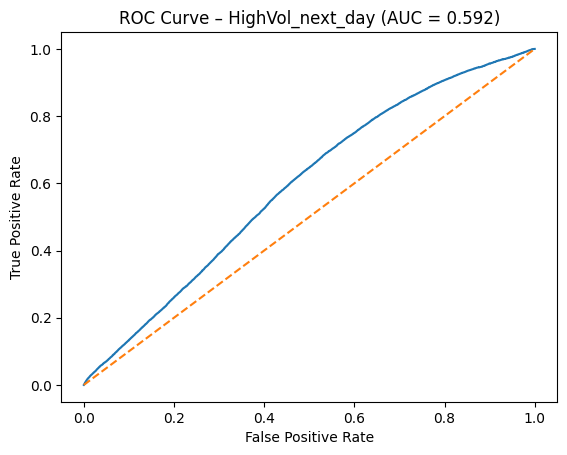

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)
 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve – HighVol_next_day (AUC = {auc:.3f})")
plt.show()


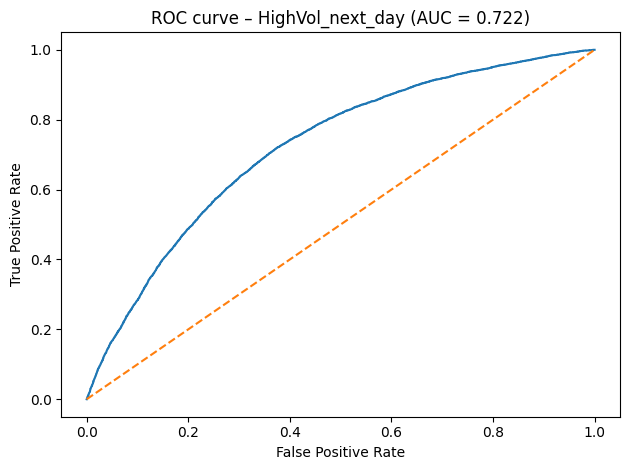

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve – HighVol_next_day (AUC = {auc:.3f})")
plt.tight_layout()
plt.show()

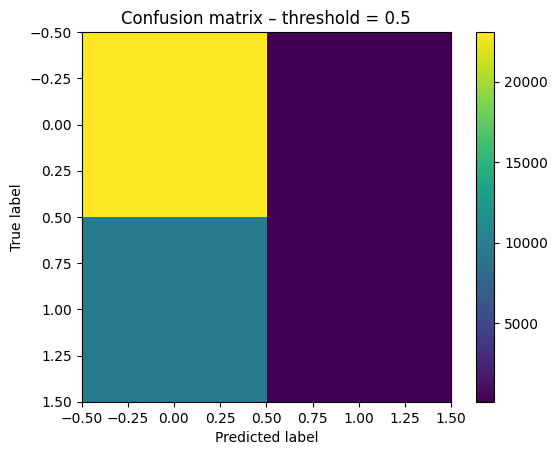

              precision    recall  f1-score   support

           0     0.7078    0.9955    0.8274     23183
           1     0.6046    0.0164    0.0320      9686

    accuracy                         0.7070     32869
   macro avg     0.6562    0.5060    0.4297     32869
weighted avg     0.6774    0.7070    0.5930     32869



In [53]:
pred_05 = (proba >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, pred_05)

plt.figure()
plt.imshow(cm_05)
plt.title("Confusion matrix – threshold = 0.5")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.show()

print(classification_report(y_test, pred_05, digits=4))

Best threshold (Youden J): 0.17313496685923402


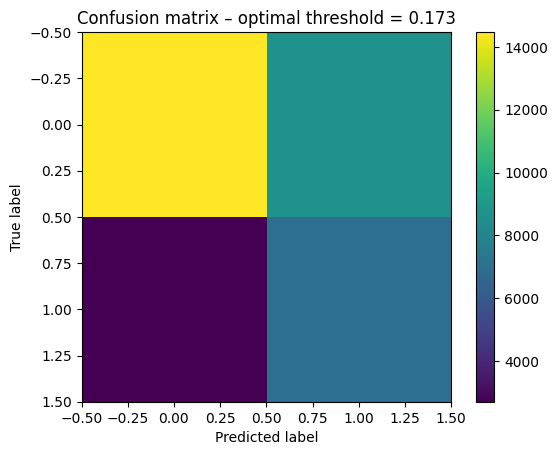

              precision    recall  f1-score   support

           0     0.8427    0.6242    0.7172     23183
           1     0.4450    0.7211    0.5504      9686

    accuracy                         0.6528     32869
   macro avg     0.6438    0.6727    0.6338     32869
weighted avg     0.7255    0.6528    0.6680     32869



In [54]:
fpr, tpr, thr = roc_curve(y_test, proba)
best_thr = thr[(tpr - fpr).argmax()]
print("Best threshold (Youden J):", best_thr)

pred_opt = (proba >= best_thr).astype(int)
cm_opt = confusion_matrix(y_test, pred_opt)

plt.figure()
plt.imshow(cm_opt)
plt.title(f"Confusion matrix – optimal threshold = {best_thr:.3f}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.show()

print(classification_report(y_test, pred_opt, digits=4))